In [1]:
import matplotlib.pyplot as plt

from models.GA.baseChromosome import LinearChromosome, Chromosome
import copy
import torch
import torch.nn as nn
import numpy as np
from models.TS.GRUPipeline import GRUFrac
from torch.utils.data import DataLoader, TensorDataset

import boto3

In [13]:
SYMBOL = "BTCUSDT"

session = boto3.session.Session()
s3 = session.client(
    service_name='s3',
    endpoint_url='https://storage.yandexcloud.net',
    aws_access_key_id='',
    aws_secret_access_key='',
    region_name='ru-central1'
)

bucket_name = 'test-actions'

train_file = f'train/all_price_{SYMBOL}.pt'
#test_file = f'test/test_{SYMBOL}.pt'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

s3.download_file(bucket_name, train_file, train_file[6:])

all_price = torch.load(f'all_price_{SYMBOL}.pt', weights_only=True).to(torch.float32).to(device)

mean, std = all_price.detach().mean().item(), all_price.detach().std().item()

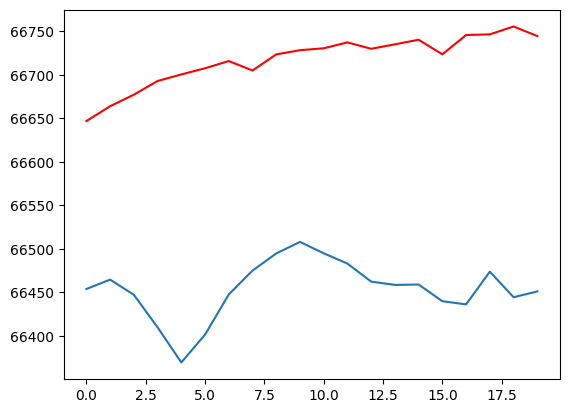

In [19]:
gru = GRUFrac(1, 40, 4, 1, mean=mean, scale=std, activation=nn.ReLU())
s3.download_file(bucket_name, f'model/weights_{SYMBOL}.pt', f'weights_{SYMBOL}.pt')
gru.load_state_dict(torch.load(f'weights_{SYMBOL}.pt', weights_only=False, map_location=torch.device(device)))

train_x = torch.stack([all_price[i:i+20].reshape(20, 1) for i in range(all_price.shape[0] - 20)]).to(device)
train_y = torch.tensor([all_price[20+i] for i in range(all_price.shape[0] - 20)]).reshape(all_price.shape[0] - 20, 1).to(device)
start = 300
l=20
plt.plot(train_y.squeeze()[start+20:start+l+20])
plt.plot(gru.predict(train_x[start].reshape(1, 20, 1), l).squeeze()[20:].detach().numpy(), color="red")
plt.show()


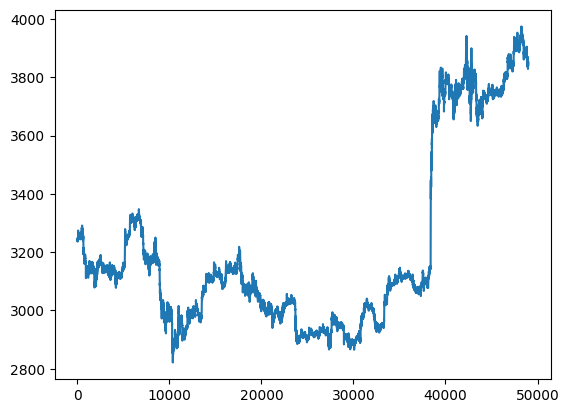

In [4]:
plt.plot(all_price)
plt.show()